In [43]:
%matplotlib inline

In [44]:
from os import path
import pandas as pd
from skimage.data import imread
from skimage.io import imshow
import numpy as np
import pandas as pd
from numpy.random import randint, seed

In [45]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD

In [46]:
nb_img = 256
nb_img_depth = 1

In [47]:
nb_pool = 2
nb_conv = 3
nb_filters = 32
nb_classes = 4

In [48]:
model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv, border_mode='valid', 
                        input_shape=(nb_img_depth, nb_img, nb_img)))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, nb_conv, nb_conv, border_mode='valid'))
model.add(Activation('relu'))
model.add(Convolution2D(64, nb_conv, nb_conv))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('softmax'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mae', optimizer='rmsprop')

In [49]:
from transform import load_training, transform_img

In [50]:
training = load_training()

In [51]:
def get_class(fga):
    if fga < 0.1:
        return 0
    elif fga < 0.2:
        return 1
    elif fga < 0.5:
        return 2
    else:
        return 3

In [52]:
training['fga_class'] = training.fga.apply(get_class)

In [53]:
def transform_pcf(training,
                  output_dir="data-%d-patches" % nb_img,
                  patch_size=nb_img,
                  fga_class_option=True):
    patch_num = 0
    for i, row in training.iterrows():
        row_patches = []
        row_output = []
        name = row['name']
        if fga_class_option:
            fga_class = row['fga_class']
        else:
            fga_class = '0'
        print("Transforming image %s" % name)
        import sys
        sys.stdout.flush()
        for kind in ["DX", "TS"]:
            img = imread("images/%s/%s-%s.png" % (kind, name, kind))
            img_patches = transform_img(img, name, patch_size=patch_size)
            from os import mkdir, path
            class_dir = path.join(output_dir, str(fga_class))
            if not path.exists(class_dir):
                mkdir(class_dir)
            for img_patch in img_patches:
                with open(path.join(output_dir, "%s/patch_file_%s_%d" % (
                            fga_class, name, patch_num)), 'w') as f:
                    np.save(f, img_patch)
                patch_num += 1

In [54]:
# transform_pcf(training)

In [55]:
fga_dict = training.set_index('name').to_dict()['fga']

In [56]:
def get_x_y(training, output_dir="data-%d-patches" % nb_img):
    from os import listdir
    from numpy.random import choice, seed
    seed(1234)
    patches = []
    outputs = []
    for fga_class in sorted(training.fga_class.unique()):
        fga_class = str(fga_class)
        print("Class %s..." % fga_class)
        import sys
        sys.stdout.flush()
        patch_files = choice(listdir(path.join(output_dir, fga_class)), 
                                     size=625, replace=False)
        for patch_file in patch_files:
            name = patch_file.split("_")[2]
            fga = fga_dict[name]
            patch = np.load(path.join(path.join(output_dir, fga_class), 
                                      patch_file))
            from skimage.feature import canny
            from skimage.color import rgb2gray
            patch = rgb2gray(patch)
            for rot in range(4):
                patches.append(np.rot90(patch, k=rot))
                outputs.append(fga)
    print("Merging X...")
    sys.stdout.flush()
    X = np.asanyarray(patches)
    print("Merging y...")
    sys.stdout.flush()
    y = np.asanyarray(outputs)
    return X, y

In [57]:
X_train, y_train = get_x_y(training)

Class 0...
Class 1...
Class 2...
Class 3...
Merging X...
Merging y...


In [58]:
# X_train = X_train.transpose((0, 3, 2, 1))
X_train = np.expand_dims(X_train, axis=0).transpose((1, 0, 2, 3))

In [59]:
model.fit(X_train, y_train, batch_size=32, nb_epoch=10)

Epoch 1/10
10000/10000 [==============================] - 264s - loss: 0.2057   
Epoch 2/10
10000/10000 [==============================] - 264s - loss: 0.1932   
Epoch 3/10
10000/10000 [==============================] - 264s - loss: 0.1929   
Epoch 4/10
  352/10000 [>.............................] - ETA: 254s - loss: 0.1906

KeyboardInterrupt: 

In [24]:
# model.evaluate(X_train, y_train, batch_size=32)

In [25]:
def load_testing():
    testing = pd.read_csv("test.csv", 
                       header=None,
                       names=['name'],
                       dtype={'name': object})
    return testing

In [26]:
testing = load_testing()

In [27]:
# transform_pcf(testing, output_dir="data-%d-patches-test" % nb_img, fga_class_option=False)

In [28]:
def get_x_test(testing, output_dir="data-%d-patches-test" % nb_img):
    from os import listdir
    from numpy.random import choice, seed
    seed(1234)
    patches = []
    outputs = []
    for i, row in testing.iterrows():
        name = row['name']
        print("X_test for %s" % name)
        import sys
        sys.stdout.flush()
        patch_files = [patch_file for patch_file in listdir(path.join(output_dir, '0')) 
                       if patch_file.split("_")[2] == name]
        patch_files = choice(patch_files, size=100, replace=False)
        for patch_file in patch_files:
            patch = np.load(path.join(path.join(output_dir, '0'), 
                                      patch_file))
            patches.append(patch)
        if i > 4:
            break
    print("Merging X...")
    sys.stdout.flush()
    X = np.asanyarray(patches)
    return X

In [ ]:
X_test = get_x_test(testing, output_dir="data-%d-patches-test" % nb_img)
X_test = X_test.transpose((0, 3, 2, 1))

In [60]:
predictions = []
for i in range(len(X_train) / 10):
    predictions.append(model.predict(X_train[i:i + 10]))

In [61]:
import itertools
merged = list(itertools.chain(*predictions))

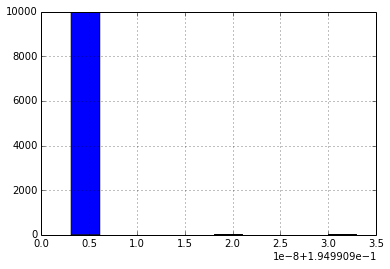

In [62]:
pd.Series(merged).hist()

In [63]:
max(merged)

array([ 0.19499093])

In [64]:
min(merged)

array([ 0.1949909])